Importing essential libraries and functions

In [32]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array

from keras.preprocessing.text import one_hot, Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split
from keras.layers import LSTM

In [33]:
df = pd.read_csv("romanized_dataset.csv").loc[:,["text", "label"]]
df.head()

,text,label
0,bajar le jasari trenda chenja garyo yo herda ...,2
1,1000 amkale ghateko nepse 200 amkale badhnu t...,1
2,hoin yo sanima baimk le bonus ghosana gareko ...,2
3,"khain MBJC prati kittama ru,10/-le badhera aa...",2
4,ram्ro bhayo️️,1


In [34]:
df = df[df["label"] != 2]
df.head()

,text,label
1,1000 amkale ghateko nepse 200 amkale badhnu t...,1
4,ram्ro bhayo️️,1
6,janakariko lagi dhanyawad ramhari bradar,1
18,bharata-madhes ra nepala-chin sambandha wigra...,0
25,"lekhanath nyaupaneko khulasa,mahadhibeshanama...",0


In [35]:
df.isnull().values.any()

False

In [36]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Removes HTML tags: replaces anything between opening and closing <> with empty space'''

    return TAG_RE.sub('', text)

In [37]:
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''
    
    sentence = sen.lower()

    # Remove html tags
    sentence = remove_tags(sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

In [38]:
# Calling preprocessing_text function on movie_reviews

X = []
sentences = list(df['text'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [39]:
y = df["label"]

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [41]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [42]:
vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

13445

In [43]:
maxlen = 50

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [44]:
# Neural Network architecture
from keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout, BatchNormalization
lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 50, input_length=maxlen)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))

lstm_model.add(Dense(1, activation='sigmoid'))

In [45]:
# Model compiling

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 50)            672250    
                                                                 
 lstm_1 (LSTM)               (None, 128)               91648     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 764,027
Trainable params: 764,027
Non-trainable params: 0
_________________________________________________________________
None


In [46]:
# Model Training

lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=5, verbose=1, validation_split=0.2)

Epoch 1/5


35/35 [==============================] - 5s 47ms/step - loss: 0.6926 - acc: 0.5215 - val_loss: 0.6888 - val_acc: 0.5528
Epoch 2/5
35/35 [==============================] - 1s 22ms/step - loss: 0.6931 - acc: 0.5118 - val_loss: 0.6902 - val_acc: 0.5574
Epoch 3/5
35/35 [==============================] - 1s 22ms/step - loss: 0.5626 - acc: 0.7042 - val_loss: 0.6564 - val_acc: 0.7456
Epoch 4/5
35/35 [==============================] - 1s 23ms/step - loss: 0.3010 - acc: 0.8891 - val_loss: 0.5862 - val_acc: 0.8127
Epoch 5/5
35/35 [==============================] - 1s 22ms/step - loss: 0.1829 - acc: 0.9435 - val_loss: 0.4886 - val_acc: 0.8118


In [54]:
# Predictions on the Test Set

score = lstm_model.evaluate(X_test, y_test, verbose=1)

43/43 [==============================] - 1s 12ms/step - loss: 0.5599 - acc: 0.7869


In [55]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.5598634481430054
Test Accuracy: 0.7869213819503784


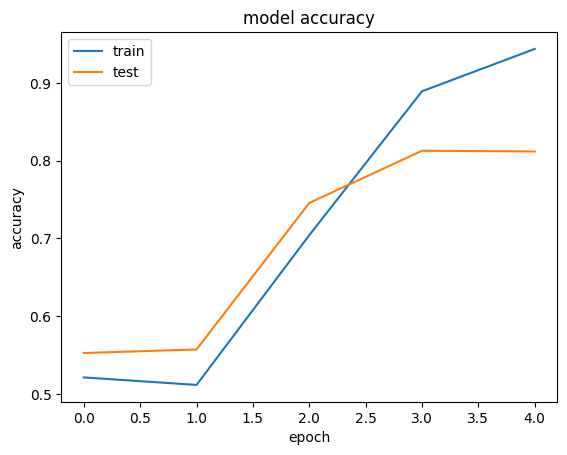

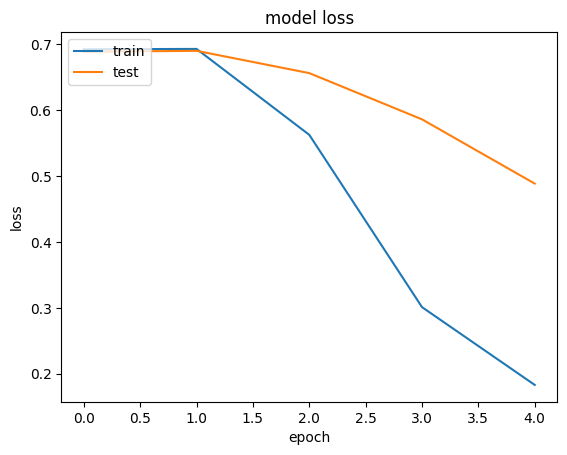

In [56]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [50]:
sample_reviews = pd.DataFrame( {
    'text': [
        'ramro lagyo',
    ],
    'label': [1]  
})

In [51]:
# Preprocess review text with earlier defined preprocess_text function

unseen_reviews = sample_reviews["text"]

unseen_processed = []
for review in unseen_reviews:
  review = preprocess_text(review)
  unseen_processed.append(review)

In [52]:
# Tokenising instance with earlier trained tokeniser
unseen_tokenized = word_tokenizer.texts_to_sequences(unseen_processed)

# Pooling instance to have maxlength of 100 tokens
unseen_padded = pad_sequences(unseen_tokenized, padding='post', maxlen=maxlen)

In [53]:
# Passing tokenised instance to the LSTM model for predictions
unseen_sentiments = lstm_model.predict(unseen_padded)

unseen_sentiments

1/1 [==============================] - 1s 565ms/step


array([[0.9651862]], dtype=float32)